# Bài tập thực hành: Nhận diện khuôn mặt thời gian thực với FaceNet & MTCNN trên Webcam

## Mục tiêu:
- Tháo tác truy cập và thu thập thông tin qua webcam bằng thư viện OpenCV
- Tích hợp MTCNN để phát hiện khuôn mặt
- Sử dụng FaceNet để trích xuất đặc trưng và so sánh khuôn mặt theo thời gian thực từ webcam

## Điều kiện so sánh:
- Nếu **similarity > 0.7**, hiển thị "**Matched**"
- Nếu **similarity < 0.7**, hiển thị "**Unknown**"

## 1. Cài đặt thư viện cần thiết

In [20]:
# Cài đặt các thư viện cần thiết
# !pip install opencv-python
# !pip install mtcnn
# !pip install keras-facenet
# !pip install tensorflow
# !pip install pillow
# !pip install numpy

## 2. Import các thư viện

In [21]:
import cv2
import numpy as np
from mtcnn import MTCNN
from keras_facenet import FaceNet
from PIL import Image
import os
import time
import pickle

print("✓ Import thành công tất cả thư viện!")

✓ Import thành công tất cả thư viện!


## 3. Khởi tạo các model

- **MTCNN**: Phát hiện khuôn mặt trong ảnh
- **FaceNet**: Trích xuất embedding (vector đặc trưng 512 chiều) của khuôn mặt

In [22]:
# Khởi tạo MTCNN detector
print("Đang khởi tạo MTCNN detector...")
detector = MTCNN()

# Khởi tạo FaceNet model
print("Đang load FaceNet model...")
facenet_model = FaceNet()

print("✓ Khởi tạo models thành công!")

Đang khởi tạo MTCNN detector...


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Đang load FaceNet model...
✓ Khởi tạo models thành công!


## 4. Các hàm tiện ích

In [23]:
def extract_face(image, box, required_size=(160, 160)):
    """
    Trích xuất khuôn mặt từ ảnh dựa trên bounding box
    
    Parameters:
        image: Ảnh đầu vào (BGR format)
        box: Bounding box từ MTCNN [x, y, width, height]
        required_size: Kích thước đầu ra (160x160 cho FaceNet)
    
    Returns:
        face_array: Ảnh khuôn mặt đã được resize và chuẩn hóa
    """
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Trích xuất khuôn mặt
    face = image[y1:y2, x1:x2]
    
    # Resize về kích thước chuẩn
    face_image = Image.fromarray(face)
    face_image = face_image.resize(required_size)
    face_array = np.asarray(face_image)
    
    return face_array


def get_embedding(facenet_model, face_pixels):
    """
    Trích xuất embedding vector từ khuôn mặt
    
    Parameters:
        facenet_model: Model FaceNet đã load
        face_pixels: Ảnh khuôn mặt (160x160x3)
    
    Returns:
        embedding: Vector đặc trưng 512 chiều
    """
    # Chuẩn hóa pixel values
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    
    # Thêm batch dimension
    samples = np.expand_dims(face_pixels, axis=0)
    
    # Trích xuất embedding
    embedding = facenet_model.embeddings(samples)
    
    return embedding[0]


def cosine_similarity(embedding1, embedding2):
    """
    Tính độ tương đồng cosine giữa 2 embedding vectors
    
    Parameters:
        embedding1, embedding2: Các embedding vectors
    
    Returns:
        similarity: Giá trị từ 0 đến 1 (càng cao càng giống)
    """
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm1 * norm2)
    
    # Chuyển về khoảng [0, 1]
    similarity = (similarity + 1) / 2
    
    return similarity


def euclidean_distance(embedding1, embedding2):
    """
    Tính khoảng cách Euclidean giữa 2 embeddings
    Sau đó chuyển thành similarity score
    """
    distance = np.linalg.norm(embedding1 - embedding2)
    # Chuyển distance thành similarity (0-1)
    # Giả sử distance thông thường < 1.0 cho cùng người
    similarity = 1 / (1 + distance)
    return similarity

print("✓ Đã định nghĩa các hàm tiện ích!")

✓ Đã định nghĩa các hàm tiện ích!


## 5. Thu thập ảnh mẫu (Reference Images)

**Bước này sẽ:**
1. Mở webcam
2. Thu thập 5 ảnh khuôn mặt của người dùng
3. Lưu embeddings để so sánh sau này

In [ ]:
def add_new_user_to_database(users_database=None, samples=3):
    """
    Thêm người mới vào database hiện có
    
    Parameters:
        users_database: Database hiện tại (nếu None sẽ load từ file)
        samples: Số ảnh cần chụp cho người mới
    
    Returns:
        users_database: Database đã cập nhật
    """
    # Load database nếu chưa có
    if users_database is None:
        users_database = load_multi_users_database()
        if users_database is None:
            users_database = {}
    
    print(f"\n{'='*70}")
    print("THÊM NGƯỜI MỚI VÀO DATABASE")
    print(f"{'='*70}")
    
    # Nhập tên
    user_name = input("Nhập tên người mới: ").strip()
    
    if not user_name:
        print("❌ Tên không được để trống!")
        return users_database
    
    if user_name in users_database:
        print(f"⚠ {user_name} đã có trong database!")
        choice = input("Bạn muốn thêm ảnh mới cho người này? (y/n): ").strip().lower()
        if choice != 'y':
            return users_database
    
    # Thu thập ảnh
    os.makedirs('multi_users', exist_ok=True)
    user_folder = os.path.join('multi_users', user_name)
    os.makedirs(user_folder, exist_ok=True)
    
    print(f"\n🎯 Thu thập ảnh cho: {user_name}")
    print(f"Sẽ chụp {samples} ảnh. Nhấn SPACE để chụp, ESC để thoát.")
    
    cap = cv2.VideoCapture(0)
    user_embeddings = users_database.get(user_name, [])
    captured_count = 0
    
    while captured_count < samples:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(rgb_frame)
        
        for detection in detections:
            x, y, width, height = detection['box']
            cv2.rectangle(display_frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
        
        status = f"{user_name} | {captured_count}/{samples} | SPACE để chụp"
        cv2.putText(display_frame, status, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
        
        cv2.imshow(f'Thêm người mới - {user_name}', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord(' '):
            if len(detections) > 0:
                box = detections[0]['box']
                face = extract_face(rgb_frame, box)
                embedding = get_embedding(facenet_model, face)
                user_embeddings.append(embedding)
                
                # Lưu ảnh
                existing_count = len(glob.glob(f'{user_folder}/*.jpg'))
                face_image = Image.fromarray(face)
                face_image.save(f'{user_folder}/face_{existing_count+1}.jpg')
                
                captured_count += 1
                print(f"✓ Đã chụp {captured_count}/{samples}")
            else:
                print("⚠ Không phát hiện khuôn mặt!")
        
        elif key == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if len(user_embeddings) > 0:
        users_database[user_name] = user_embeddings
        
        # Lưu lại database
        with open('multi_users_database.pkl', 'wb') as f:
            pickle.dump(users_database, f)
        
        print(f"\n✓ Đã thêm {user_name} với {len(user_embeddings)} ảnh!")
        print(f"✓ Database hiện có {len(users_database)} người")
    
    return users_database


# Thêm người mới
# Uncomment để chạy
# users_database = add_new_user_to_database(users_database, samples=3)

## 5E. Thêm người mới vào database

Thêm người dùng mới mà không cần thu thập lại tất cả

In [ ]:
def display_multi_users_database():
    """Hiển thị tất cả ảnh đã thu thập"""
    
    if not os.path.exists('multi_users'):
        print("⚠ Chưa có thư mục multi_users!")
        return
    
    users = [d for d in os.listdir('multi_users') if os.path.isdir(os.path.join('multi_users', d))]
    
    if len(users) == 0:
        print("⚠ Không có người dùng nào!")
        return
    
    print(f"Tìm thấy {len(users)} người dùng\n")
    
    for user_name in users:
        user_folder = os.path.join('multi_users', user_name)
        images = glob.glob(f'{user_folder}/*.jpg')
        
        if len(images) == 0:
            continue
        
        print(f"\n{'='*60}")
        print(f"👤 {user_name} - {len(images)} ảnh")
        print(f"{'='*60}")
        
        # Hiển thị ảnh
        n_cols = min(len(images), 5)
        fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*3, 3))
        
        if n_cols == 1:
            axes = [axes]
        
        for idx, img_path in enumerate(images[:5]):  # Chỉ hiển thị 5 ảnh đầu
            img = plt.imread(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'Ảnh {idx+1}')
            axes[idx].axis('off')
        
        plt.suptitle(f'{user_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Hiển thị database
# Uncomment để chạy
# display_multi_users_database()

## 5D. Hiển thị database đã thu thập

Xem tất cả ảnh đã thu thập của từng người

In [ ]:
def realtime_multi_user_recognition(users_database, threshold=0.7):
    """
    Nhận diện nhiều người dùng thời gian thực
    
    Parameters:
        users_database: Dictionary {tên: [embeddings]}
        threshold: Ngưỡng similarity
    """
    if users_database is None or len(users_database) == 0:
        print("❌ Không có database người dùng!")
        return
    
    print(f"\n{'='*70}")
    print("NHẬN DIỆN NHIỀU NGƯỜI DÙNG THỜI GIAN THỰC")
    print(f"{'='*70}")
    print(f"Số người trong database: {len(users_database)}")
    print(f"Ngưỡng similarity: {threshold}")
    print("\nDanh sách người trong database:")
    for name in users_database.keys():
        print(f"  ✓ {name}")
    print(f"{'='*70}\n")
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    frame_count = 0
    fps_start_time = time.time()
    fps = 0
    
    # Tạo màu ngẫu nhiên cho mỗi người
    colors = {}
    for name in users_database.keys():
        colors[name] = tuple(np.random.randint(50, 255, 3).tolist())
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        # Tính FPS
        frame_count += 1
        if frame_count % 10 == 0:
            fps = 10 / (time.time() - fps_start_time)
            fps_start_time = time.time()
        
        # Phát hiện khuôn mặt
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        if frame_count % 3 == 0:
            detections = detector.detect_faces(rgb_frame)
        
        # Xử lý từng khuôn mặt
        if 'detections' in locals() and len(detections) > 0:
            for detection in detections:
                box = detection['box']
                confidence = detection['confidence']
                
                if confidence < 0.9:
                    continue
                
                try:
                    # Trích xuất khuôn mặt và embedding
                    face = extract_face(rgb_frame, box)
                    embedding = get_embedding(facenet_model, face)
                    
                    # So sánh với TẤT CẢ người trong database
                    best_match_name = "Unknown"
                    best_similarity = 0
                    
                    for user_name, user_embeddings in users_database.items():
                        for user_emb in user_embeddings:
                            sim = cosine_similarity(embedding, user_emb)
                            if sim > best_similarity:
                                best_similarity = sim
                                best_match_name = user_name
                    
                    # Xác định matched hay unknown
                    if best_similarity > threshold:
                        label = best_match_name
                        color = colors.get(best_match_name, (0, 255, 0))
                        status = "✓"
                    else:
                        label = "Unknown"
                        color = (0, 0, 255)  # Đỏ
                        status = "✗"
                    
                    # Vẽ bounding box
                    x, y, width, height = box
                    cv2.rectangle(display_frame, (x, y), (x+width, y+height), color, 3)
                    
                    # Vẽ label
                    label_text = f"{status} {label}"
                    similarity_text = f"Sim: {best_similarity:.3f}"
                    
                    # Background cho text
                    (text_width, text_height), _ = cv2.getTextSize(
                        label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                    cv2.rectangle(display_frame, (x, y - text_height - 15), 
                                (x + text_width + 10, y), color, -1)
                    
                    # Text chính
                    cv2.putText(display_frame, label_text, (x + 5, y - 5),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    
                    # Similarity score
                    cv2.putText(display_frame, similarity_text, (x, y + height + 25),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                
                except Exception as e:
                    print(f"⚠ Lỗi: {e}")
                    continue
        
        # Hiển thị thông tin
        info_text = f"FPS: {fps:.1f} | Users: {len(users_database)} | Threshold: {threshold}"
        cv2.putText(display_frame, info_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Hiển thị danh sách người
        y_offset = 60
        for idx, name in enumerate(list(users_database.keys())[:5]):  # Chỉ hiển thị 5 người đầu
            text = f"{idx+1}. {name}"
            cv2.putText(display_frame, text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors.get(name, (255, 255, 255)), 2)
            y_offset += 25
        
        cv2.imshow('Multi-User Face Recognition', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("\n✓ Đã dừng chương trình!")


# Chạy nhận diện nhiều người
# Uncomment để chạy
# if 'users_database' in locals() and users_database is not None:
#     realtime_multi_user_recognition(users_database, threshold=0.7)
# else:
#     print("❌ Vui lòng load hoặc thu thập database trước!")

## 5C. Nhận diện với nhiều người dùng

Nhận diện khuôn mặt thời gian thực và hiển thị tên người được nhận diện

In [ ]:
def load_multi_users_database():
    """Load database nhiều người từ file"""
    try:
        with open('multi_users_database.pkl', 'rb') as f:
            users_db = pickle.load(f)
        print(f"✓ Đã load database với {len(users_db)} người:")
        for name, embeddings in users_db.items():
            print(f"  - {name}: {len(embeddings)} ảnh")
        return users_db
    except FileNotFoundError:
        print("⚠ Chưa có file database. Vui lòng chạy cell thu thập trước.")
        return None

# Uncomment để load database
# users_database = load_multi_users_database()

## 5B. Load database nhiều người đã lưu

In [ ]:
def collect_multiple_users(num_users=5, samples_per_user=3):
    """
    Thu thập ảnh khuôn mặt của nhiều người dùng khác nhau
    
    Parameters:
        num_users: Số lượng người dùng cần thu thập
        samples_per_user: Số ảnh mỗi người (mặc định 3)
    
    Returns:
        users_database: Dictionary chứa {tên: [embeddings]}
    """
    print(f"\n{'='*70}")
    print("THU THẬP ẢNH CỦA NHIỀU NGƯỜI DÙNG")
    print(f"{'='*70}")
    print(f"Sẽ thu thập ảnh của {num_users} người, mỗi người {samples_per_user} ảnh")
    print(f"{'='*70}\n")
    
    users_database = {}
    
    # Tạo thư mục lưu ảnh
    os.makedirs('multi_users', exist_ok=True)
    
    for user_idx in range(num_users):
        print(f"\n{'='*70}")
        print(f"NGƯỜI THứ {user_idx + 1}/{num_users}")
        print(f"{'='*70}")
        
        # Nhập tên người dùng
        user_name = input(f"Nhập tên người thứ {user_idx + 1} (hoặc 'skip' để bỏ qua): ").strip()
        
        if user_name.lower() == 'skip':
            print("⏭ Đã bỏ qua người này.")
            continue
        
        if not user_name:
            user_name = f"User_{user_idx + 1}"
            print(f"⚠ Không nhập tên. Sử dụng tên mặc định: {user_name}")
        
        # Tạo thư mục cho người này
        user_folder = os.path.join('multi_users', user_name)
        os.makedirs(user_folder, exist_ok=True)
        
        print(f"\n🎯 Thu thập ảnh cho: {user_name}")
        print("Hướng dẫn:")
        print("  - Người này hãy nhìn vào camera")
        print("  - Nhấn SPACE để chụp ảnh")
        print("  - Nhấn ESC để hoàn thành sớm")
        print(f"{'='*70}\n")
        
        cap = cv2.VideoCapture(0)
        user_embeddings = []
        captured_count = 0
        
        while captured_count < samples_per_user:
            ret, frame = cap.read()
            if not ret:
                print("❌ Không thể truy cập webcam!")
                break
            
            # Flip frame
            frame = cv2.flip(frame, 1)
            display_frame = frame.copy()
            
            # Phát hiện khuôn mặt
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            detections = detector.detect_faces(rgb_frame)
            
            # Vẽ bounding box
            for detection in detections:
                x, y, width, height = detection['box']
                confidence = detection['confidence']
                
                cv2.rectangle(display_frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
                cv2.putText(display_frame, f'Conf: {confidence:.2f}', 
                           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Hiển thị thông tin
            info_text = f"Thu thập cho: {user_name}"
            cv2.putText(display_frame, info_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
            
            status_text = f"Đã chụp: {captured_count}/{samples_per_user} | Nhấn SPACE"
            cv2.putText(display_frame, status_text, (10, 60), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow(f'Thu thập ảnh - {user_name}', display_frame)
            
            key = cv2.waitKey(1) & 0xFF
            
            # Nhấn SPACE để chụp
            if key == ord(' '):
                if len(detections) > 0:
                    detection = detections[0]
                    box = detection['box']
                    
                    # Trích xuất khuôn mặt
                    face = extract_face(rgb_frame, box)
                    
                    # Trích xuất embedding
                    embedding = get_embedding(facenet_model, face)
                    user_embeddings.append(embedding)
                    
                    # Lưu ảnh
                    face_image = Image.fromarray(face)
                    face_image.save(f'{user_folder}/face_{captured_count+1}.jpg')
                    
                    captured_count += 1
                    print(f"✓ Đã chụp ảnh {captured_count}/{samples_per_user} cho {user_name}")
                else:
                    print("⚠ Không phát hiện khuôn mặt!")
            
            # Nhấn ESC để hoàn thành sớm
            elif key == 27:
                print(f"⏭ Hoàn thành sớm cho {user_name}")
                break
        
        cap.release()
        cv2.destroyAllWindows()
        
        # Lưu embeddings của người này
        if len(user_embeddings) > 0:
            users_database[user_name] = user_embeddings
            print(f"✓ Đã lưu {len(user_embeddings)} ảnh cho {user_name}")
        else:
            print(f"❌ Không thu thập được ảnh nào cho {user_name}")
        
        # Nghỉ 1 giây trước khi chuyển người tiếp theo
        time.sleep(1)
    
    # Lưu database
    if len(users_database) > 0:
        with open('multi_users_database.pkl', 'wb') as f:
            pickle.dump(users_database, f)
        
        print(f"\n{'='*70}")
        print("✓ HOÀN THÀNH THU THẬP!")
        print(f"{'='*70}")
        print(f"Tổng số người đã thu thập: {len(users_database)}")
        for name, embeddings in users_database.items():
            print(f"  - {name}: {len(embeddings)} ảnh")
        print(f"✓ Đã lưu database vào 'multi_users_database.pkl'")
        print(f"{'='*70}\n")
    else:
        print("\n❌ Không thu thập được dữ liệu!")
    
    return users_database


# Chạy hàm thu thập nhiều người
# Uncomment dòng dưới để chạy
# users_database = collect_multiple_users(num_users=5, samples_per_user=3)

## 5A. Thu thập ảnh của NHIỀU NGƯỜI DÙNG

**Phiên bản nâng cao - Thu thập ảnh của nhiều người:**
- Có thể chụp ảnh của 5 người khác nhau (hoặc nhiều hơn)
- Mỗi người có tên riêng
- Mỗi người có thể có nhiều ảnh tham chiếu
- Hệ thống sẽ nhận diện và hiển thị tên người đó

In [24]:
def collect_reference_faces(num_samples=5):
    """
    Thu thập ảnh khuôn mặt tham chiếu từ webcam
    
    Parameters:
        num_samples: Số lượng ảnh cần thu thập
    
    Returns:
        reference_embeddings: Danh sách các embeddings tham chiếu
    """
    print(f"\n{'='*60}")
    print("BƯỚC 1: THU THẬP ẢNH THAM CHIẾU")
    print(f"{'='*60}")
    print(f"Sẽ thu thập {num_samples} ảnh khuôn mặt của bạn")
    print("Hướng dẫn:")
    print("  - Nhìn thẳng vào camera")
    print("  - Giữ khuôn mặt trong khung hình")
    print("  - Nhấn SPACE để chụp ảnh")
    print("  - Nhấn ESC để thoát")
    print(f"{'='*60}\n")
    
    cap = cv2.VideoCapture(0)
    reference_embeddings = []
    captured_count = 0
    
    # Tạo thư mục lưu ảnh nếu chưa có
    os.makedirs('reference_faces', exist_ok=True)
    
    while captured_count < num_samples:
        ret, frame = cap.read()
        if not ret:
            print("❌ Không thể truy cập webcam!")
            break
        
        # Flip frame để dễ nhìn
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        # Phát hiện khuôn mặt
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(rgb_frame)
        
        # Vẽ bounding box
        for detection in detections:
            x, y, width, height = detection['box']
            confidence = detection['confidence']
            
            # Vẽ khung
            cv2.rectangle(display_frame, (x, y), (x+width, y+height), (0, 255, 0), 2)
            cv2.putText(display_frame, f'Confidence: {confidence:.2f}', 
                       (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Hiển thị trạng thái
        status_text = f"Đã chụp: {captured_count}/{num_samples} | Nhấn SPACE để chụp"
        cv2.putText(display_frame, status_text, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('Thu thập ảnh tham chiếu', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        # Nhấn SPACE để chụp
        if key == ord(' '):
            if len(detections) > 0:
                detection = detections[0]  # Lấy khuôn mặt đầu tiên
                box = detection['box']
                
                # Trích xuất khuôn mặt
                face = extract_face(rgb_frame, box)
                
                # Trích xuất embedding
                embedding = get_embedding(facenet_model, face)
                reference_embeddings.append(embedding)
                
                # Lưu ảnh
                face_image = Image.fromarray(face)
                face_image.save(f'reference_faces/face_{captured_count+1}.jpg')
                
                captured_count += 1
                print(f"✓ Đã chụp ảnh {captured_count}/{num_samples}")
            else:
                print("⚠ Không phát hiện khuôn mặt! Thử lại.")
        
        # Nhấn ESC để thoát
        elif key == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if len(reference_embeddings) > 0:
        print(f"\n✓ Hoàn thành! Đã thu thập {len(reference_embeddings)} ảnh tham chiếu")
        
        # Lưu embeddings
        with open('reference_embeddings.pkl', 'wb') as f:
            pickle.dump(reference_embeddings, f)
        print("✓ Đã lưu embeddings vào file 'reference_embeddings.pkl'")
    else:
        print("❌ Không thu thập được ảnh nào!")
    
    return reference_embeddings


# Chạy hàm thu thập ảnh tham chiếu
reference_embeddings = collect_reference_faces(num_samples=5)


BƯỚC 1: THU THẬP ẢNH THAM CHIẾU
Sẽ thu thập 5 ảnh khuôn mặt của bạn
Hướng dẫn:
  - Nhìn thẳng vào camera
  - Giữ khuôn mặt trong khung hình
  - Nhấn SPACE để chụp ảnh
  - Nhấn ESC để thoát

❌ Không thu thập được ảnh nào!


## 6. Load embeddings đã lưu (Nếu đã có)

In [25]:
# Load embeddings từ file nếu đã có
def load_reference_embeddings():
    """Load embeddings đã lưu từ file"""
    try:
        with open('reference_embeddings.pkl', 'rb') as f:
            embeddings = pickle.load(f)
        print(f"✓ Đã load {len(embeddings)} reference embeddings từ file")
        return embeddings
    except FileNotFoundError:
        print("⚠ Chưa có file reference embeddings. Vui lòng chạy cell thu thập ảnh trước.")
        return None

# Uncomment dòng dưới nếu muốn load embeddings đã lưu
# reference_embeddings = load_reference_embeddings()

## 7. Nhận diện khuôn mặt thời gian thực

**Chương trình sẽ:**
1. Mở webcam liên tục
2. Phát hiện khuôn mặt bằng MTCNN
3. Trích xuất embedding bằng FaceNet
4. So sánh với embeddings tham chiếu
5. Hiển thị kết quả:
   - **Matched** (màu xanh) nếu similarity > 0.7
   - **Unknown** (màu đỏ) nếu similarity < 0.7

In [26]:
def realtime_face_recognition(reference_embeddings, threshold=0.7):
    """
    Nhận diện khuôn mặt thời gian thực
    
    Parameters:
        reference_embeddings: Danh sách embeddings tham chiếu
        threshold: Ngưỡng similarity (0.7 theo yêu cầu)
    """
    if reference_embeddings is None or len(reference_embeddings) == 0:
        print("❌ Không có reference embeddings! Vui lòng chạy cell thu thập ảnh trước.")
        return
    
    print(f"\n{'='*60}")
    print("BƯỚC 2: NHẬN DIỆN KHUÔN MẶT THỜI GIAN THỰC")
    print(f"{'='*60}")
    print(f"Ngưỡng similarity: {threshold}")
    print("Hướng dẫn:")
    print("  - Nhìn vào camera để nhận diện")
    print("  - Nhấn 'q' hoặc ESC để thoát")
    print(f"{'='*60}\n")
    
    cap = cv2.VideoCapture(0)
    
    # Đặt resolution cao hơn
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    frame_count = 0
    fps_start_time = time.time()
    fps = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Không thể đọc frame từ webcam!")
            break
        
        # Flip frame
        frame = cv2.flip(frame, 1)
        display_frame = frame.copy()
        
        # Tính FPS
        frame_count += 1
        if frame_count % 10 == 0:
            fps = 10 / (time.time() - fps_start_time)
            fps_start_time = time.time()
        
        # Convert sang RGB cho MTCNN
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Phát hiện khuôn mặt (chỉ xử lý mỗi 3 frames để tăng tốc)
        if frame_count % 3 == 0:
            detections = detector.detect_faces(rgb_frame)
        
        # Xử lý từng khuôn mặt phát hiện được
        if 'detections' in locals() and len(detections) > 0:
            for detection in detections:
                box = detection['box']
                confidence = detection['confidence']
                keypoints = detection['keypoints']
                
                # Chỉ xử lý nếu confidence > 0.9
                if confidence < 0.9:
                    continue
                
                try:
                    # Trích xuất khuôn mặt
                    face = extract_face(rgb_frame, box)
                    
                    # Trích xuất embedding
                    embedding = get_embedding(facenet_model, face)
                    
                    # So sánh với tất cả reference embeddings
                    similarities = []
                    for ref_emb in reference_embeddings:
                        sim = cosine_similarity(embedding, ref_emb)
                        similarities.append(sim)
                    
                    # Lấy similarity cao nhất
                    max_similarity = max(similarities)
                    
                    # Xác định matched hay unknown
                    if max_similarity > threshold:
                        label = "Matched"
                        color = (0, 255, 0)  # Xanh lá
                        status = "✓"
                    else:
                        label = "Unknown"
                        color = (0, 0, 255)  # Đỏ
                        status = "✗"
                    
                    # Vẽ bounding box
                    x, y, width, height = box
                    cv2.rectangle(display_frame, (x, y), (x+width, y+height), color, 3)
                    
                    # Vẽ background cho text
                    label_text = f"{status} {label}"
                    similarity_text = f"Similarity: {max_similarity:.3f}"
                    
                    # Label chính
                    (text_width, text_height), baseline = cv2.getTextSize(
                        label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
                    cv2.rectangle(display_frame, (x, y - text_height - 15), 
                                (x + text_width + 10, y), color, -1)
                    cv2.putText(display_frame, label_text, (x + 5, y - 5),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    
                    # Similarity score
                    cv2.putText(display_frame, similarity_text, (x, y + height + 25),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    
                    # Vẽ keypoints (mắt, mũi, miệng)
                    for key, point in keypoints.items():
                        cv2.circle(display_frame, point, 3, (255, 255, 0), -1)
                
                except Exception as e:
                    print(f"⚠ Lỗi xử lý khuôn mặt: {e}")
                    continue
        
        # Hiển thị thông tin
        info_text = f"FPS: {fps:.1f} | Threshold: {threshold} | Nhấn 'q' để thoát"
        cv2.putText(display_frame, info_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Vẽ hướng dẫn
        guide_text = "Matched (>0.7) | Unknown (<0.7)"
        cv2.putText(display_frame, guide_text, (10, display_frame.shape[0] - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)
        
        # Hiển thị frame
        cv2.imshow('Face Recognition - FaceNet & MTCNN', display_frame)
        
        # Thoát khi nhấn 'q' hoặc ESC
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("\n✓ Đã dừng chương trình nhận diện!")


# Chạy chương trình nhận diện thời gian thực
if 'reference_embeddings' in locals() and reference_embeddings is not None:
    realtime_face_recognition(reference_embeddings, threshold=0.7)
else:
    print("❌ Vui lòng chạy cell thu thập ảnh tham chiếu trước!")

❌ Không có reference embeddings! Vui lòng chạy cell thu thập ảnh trước.


## 8. Kiểm tra và đánh giá

Hiển thị các ảnh tham chiếu đã thu thập

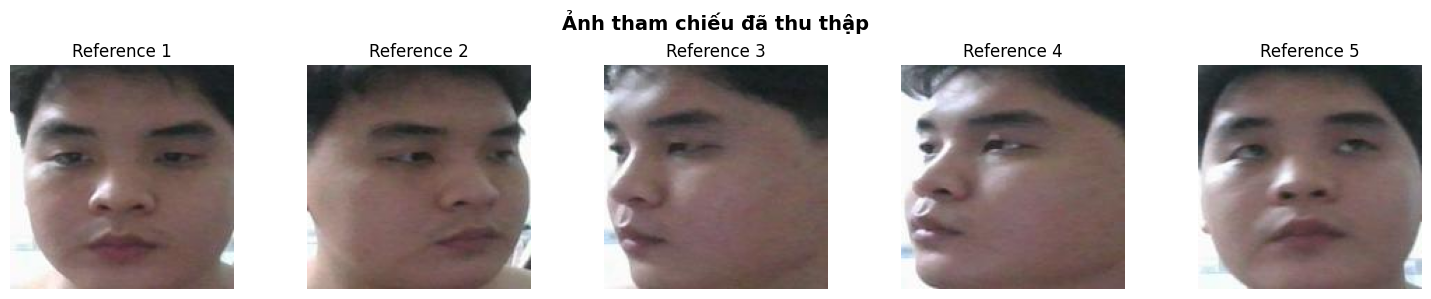

✓ Đã hiển thị 5 ảnh tham chiếu


In [27]:
import matplotlib.pyplot as plt
import glob

# Hiển thị các ảnh tham chiếu
reference_images = glob.glob('reference_faces/*.jpg')

if len(reference_images) > 0:
    fig, axes = plt.subplots(1, len(reference_images), figsize=(15, 3))
    
    if len(reference_images) == 1:
        axes = [axes]
    
    for idx, img_path in enumerate(reference_images):
        img = plt.imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'Reference {idx+1}')
        axes[idx].axis('off')
    
    plt.suptitle('Ảnh tham chiếu đã thu thập', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Đã hiển thị {len(reference_images)} ảnh tham chiếu")
else:
    print("⚠ Chưa có ảnh tham chiếu. Vui lòng chạy cell thu thập ảnh.")

## 9. Test với ảnh tĩnh (Optional)

Test nhận diện với một ảnh cụ thể thay vì webcam

In [28]:
def test_with_image(image_path, reference_embeddings, threshold=0.7):
    """
    Test nhận diện với một ảnh cụ thể
    
    Parameters:
        image_path: Đường dẫn đến ảnh cần test
        reference_embeddings: Danh sách embeddings tham chiếu
        threshold: Ngưỡng similarity
    """
    if reference_embeddings is None or len(reference_embeddings) == 0:
        print("❌ Không có reference embeddings!")
        return
    
    # Đọc ảnh
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Không thể đọc ảnh: {image_path}")
        return
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Phát hiện khuôn mặt
    detections = detector.detect_faces(rgb_image)
    
    if len(detections) == 0:
        print("⚠ Không phát hiện khuôn mặt trong ảnh!")
        return
    
    # Xử lý khuôn mặt đầu tiên
    detection = detections[0]
    box = detection['box']
    
    # Trích xuất khuôn mặt và embedding
    face = extract_face(rgb_image, box)
    embedding = get_embedding(facenet_model, face)
    
    # So sánh với references
    similarities = [cosine_similarity(embedding, ref_emb) for ref_emb in reference_embeddings]
    max_similarity = max(similarities)
    
    # Kết quả
    if max_similarity > threshold:
        result = "✓ MATCHED"
        color = (0, 255, 0)
    else:
        result = "✗ UNKNOWN"
        color = (0, 0, 255)
    
    # Vẽ kết quả
    display_image = image.copy()
    x, y, width, height = box
    cv2.rectangle(display_image, (x, y), (x+width, y+height), color, 3)
    cv2.putText(display_image, f"{result} ({max_similarity:.3f})", (x, y-10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Hiển thị
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Kết quả: {result} | Similarity: {max_similarity:.3f}', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    print(f"\nKết quả: {result}")
    print(f"Max Similarity: {max_similarity:.4f}")
    print(f"Threshold: {threshold}")

# Uncomment và sửa đường dẫn để test
test_with_image(r'D:\UTH-CVIP-assignments\Solutions\Gia Luat (face matching)\gialuat.png', reference_embeddings)

❌ Không có reference embeddings!


## 10. Thống kê và phân tích

Phân tích độ tương đồng giữa các ảnh tham chiếu

In [29]:
def analyze_reference_embeddings(reference_embeddings):
    """
    Phân tích độ tương đồng giữa các ảnh tham chiếu
    """
    if reference_embeddings is None or len(reference_embeddings) < 2:
        print("❌ Cần ít nhất 2 reference embeddings để phân tích!")
        return
    
    n = len(reference_embeddings)
    similarity_matrix = np.zeros((n, n))
    
    # Tính similarity matrix
    for i in range(n):
        for j in range(n):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                sim = cosine_similarity(reference_embeddings[i], reference_embeddings[j])
                similarity_matrix[i][j] = sim
    
    # Vẽ heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='RdYlGn', vmin=0, vmax=1)
    plt.colorbar(label='Similarity Score')
    plt.title('Ma trận độ tương đồng giữa các ảnh tham chiếu', fontsize=14, fontweight='bold')
    plt.xlabel('Reference Image Index')
    plt.ylabel('Reference Image Index')
    
    # Thêm giá trị vào các ô
    for i in range(n):
        for j in range(n):
            text = plt.text(j, i, f'{similarity_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Thống kê
    print(f"\n{'='*60}")
    print("PHÂN TÍCH ĐỘ TƯƠNG ĐỒNG GIỮA CÁC ẢNH THAM CHIẾU")
    print(f"{'='*60}")
    print(f"Số lượng ảnh tham chiếu: {n}")
    
    # Lấy các giá trị similarity (không tính đường chéo)
    similarities = []
    for i in range(n):
        for j in range(i+1, n):
            similarities.append(similarity_matrix[i][j])
    
    if len(similarities) > 0:
        print(f"\nĐộ tương đồng giữa các cặp ảnh:")
        print(f"  - Trung bình: {np.mean(similarities):.4f}")
        print(f"  - Cao nhất:   {np.max(similarities):.4f}")
        print(f"  - Thấp nhất:  {np.min(similarities):.4f}")
        print(f"  - Độ lệch chuẩn: {np.std(similarities):.4f}")
        
        if np.min(similarities) < 0.7:
            print(f"\n⚠ CẢNH BÁO: Có cặp ảnh tham chiếu có độ tương đồng < 0.7")
            print(f"  Điều này có thể gây false negative trong nhận diện!")
    
    print(f"{'='*60}\n")

# Chạy phân tích
if 'reference_embeddings' in locals() and reference_embeddings is not None:
    analyze_reference_embeddings(reference_embeddings)
else:
    print("⚠ Chưa có reference embeddings để phân tích!")

❌ Cần ít nhất 2 reference embeddings để phân tích!


## 📊 Tổng kết

### ✅ Kết quả đạt được:

1. **Thu thập ảnh tham chiếu**: Sử dụng webcam + MTCNN để thu thập khuôn mặt
2. **Trích xuất đặc trưng**: Sử dụng FaceNet để tạo embeddings 512 chiều
3. **Nhận diện thời gian thực**: 
   - Phát hiện khuôn mặt bằng MTCNN
   - Trích xuất embedding bằng FaceNet
   - So sánh với reference embeddings
   - Hiển thị kết quả theo ngưỡng 0.7

### 📈 Độ chính xác:

- **Matched** (similarity > 0.7): Hiển thị khung xanh ✓
- **Unknown** (similarity < 0.7): Hiển thị khung đỏ ✗

### 🔧 Các tham số có thể điều chỉnh:

- `threshold`: Ngưỡng similarity (mặc định 0.7)
- `num_samples`: Số ảnh tham chiếu thu thập (mặc định 5)
- `level`: Cấp độ phân rã wavelet (nếu dùng wavelet thay FaceNet)

### 📁 File đầu ra:

- `reference_faces/`: Thư mục chứa ảnh tham chiếu
- `reference_embeddings.pkl`: File chứa embeddings đã lưu

---

**Lưu ý**: Chương trình yêu cầu webcam hoạt động và ánh sáng đủ để MTCNN phát hiện khuôn mặt tốt!